In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -q "/content/drive/MyDrive/archive.zip" -d /content/

# Variational Autoencoder for Image Enhancement: Training and Visualization

In this project, we develop a Variational Autoencoder (VAE) model using PyTorch to enhance underwater images. The model is designed to denoise images by applying a forward diffusion process, followed by a reverse process using a U-Net architecture. This write-up outlines the key components of the implementation, including data preparation, model architecture, training, and visualization of results.

## 1. Data Preparation

### Importing Libraries

In [3]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


## Loading Training Data

The training data consists of raw images located in the specified directory. We utilize the `ImageDataGenerator` class from TensorFlow to load and preprocess the images, including normalization to the range [0, 1]. The images are resized to 224x224 pixels for uniformity.

In [4]:
# Set paths for training and reference directories
train_dir = '/content/Train'  # Update this to your train directory path


In [5]:
# Initialize ImageDataGenerators
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

# Load images from train directory (for raw images)
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    shuffle=True
)


Found 1400 images belonging to 2 classes.


In [6]:
# Initialize empty lists to hold image data
X_train = []

# Get number of samples
num_train_samples = train_generator.n


# Iterate through the train generator and store images in X_train
for batch in train_generator:
    X_train.append(batch[0])  # Append the first element which contains the image data
    if len(X_train) * train_generator.batch_size >= num_train_samples:
        break

# Convert lists to numpy arrays
X_train = np.concatenate(X_train, axis=0)


# Normalize images
X_train = (X_train - 127.5) / 127.5  # Scale to [-1, 1]


# Output shapes
print(f"X_train shape: {X_train.shape}")


X_train shape: (1400, 224, 224, 3)


In [8]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 45.8 MB/s eta 0:00:00


## 2. Defining the Dataset Class

We define a custom dataset class, `UnderwaterDataset`, that inherits from PyTorch’s `Dataset` class. This class enables us to handle our image data efficiently and provides methods for accessing the dataset.


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from torchmetrics import StructuralSimilarityIndexMeasure


# Define a custom dataset for underwater images
class UnderwaterDataset(Dataset):
    def __init__(self, X_train):
        self.data = X_train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Transform image to match PyTorch's format (C, H, W)
        image = self.data[idx].transpose((2, 0, 1))  # From (H, W, C) to (C, H, W)
        image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
        return image


## 3. Forward Diffusion Process

We implement the forward diffusion process, which adds noise to the images to simulate the effect of corruption. This step is crucial for training our model to learn how to denoise images effectively.

In [10]:
#Modify the forward diffusion process for underwater images
def forward_diffusion(x0, noise, t, T):
    """
    Applies the forward diffusion process.

    Args:
    - x0: Original image tensor (batch_size, channels, height, width)
    - noise: Gaussian noise tensor with the same shape as x0
    - t: Current time step in the diffusion process
    - T: Total number of time steps

    Returns:
    - xt: Noised image tensor at time step t
    """
    alpha = 1 - (t / T)  # Simple linear schedule
    return alpha * x0 + (1 - alpha) * noise


## 4. U-Net Architecture for Denoising

A simple U-Net-like model is defined to reconstruct the original images from the noisy versions. The U-Net architecture consists of an encoder for downsampling and a decoder for upsampling.

In [11]:
# Simple U-Net-like model for reverse process (denoising)
class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleUNet, self).__init__()

        # Encoder (downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Decoder (upsampling)
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output in range [0, 1] for image generation
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## 5. Training Configuration

The training hyperparameters, including the number of time steps (T), batch size, learning rate, and number of epochs, are defined. The model is moved to the appropriate device (GPU or CPU)

In [19]:
# Hyperparameters
T = 1000  # Number of time steps
batch_size = 8
learning_rate = 1e-4
epochs = 10

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your underwater dataset (assuming X_train is provided with shape [1400, 224, 224, 3])
# X_train = np.load("X_train.npy")  # Uncomment if loading from file
dataset = UnderwaterDataset(X_train=X_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, optimizer, loss
model = SimpleUNet(in_channels=3, out_channels=3)  # RGB images have 3 channels
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


In [20]:
# Initialize SSIM metric and move it to the same device as the model
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # Set data_range to 1 since images are normalized


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


## 6. Training Loop

The training loop iterates through the dataset for the specified number of epochs. In each iteration, noise is added to the images using the forward diffusion process. The model attempts to reconstruct the original images from the noisy input. The Mean Squared Error (MSE), Peak Signal-to-Noise Ratio (PSNR), and Structural Similarity Index Measure (SSIM) are calculated to evaluate performance.


In [21]:
# Variables to track losses
mse_losses = []
psnr_scores = []
ssim_scores = []

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_mse = 0
    epoch_psnr = 0
    epoch_ssim = 0

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)  # Move input data to the same device
        optimizer.zero_grad()

        # Apply forward diffusion (add noise)
        noise = torch.randn_like(data)
        t = torch.randint(0, T, (data.shape[0],)).view(-1, 1, 1, 1).to(device)  # Random time steps, reshaped to broadcast
        xt = forward_diffusion(data, noise, t, T)

        # Denoising step: predict original image from noisy image
        reconstructed = model(xt)
        loss = criterion(reconstructed, data)

        loss.backward()
        optimizer.step()

        # Calculate losses and metrics
        mse_loss = loss.item()
        epoch_mse += mse_loss

        # PSNR calculation using original PyTorch tensors
        batch_psnr = 0
        for i in range(data.size(0)):  # Calculate PSNR per image in the batch
            orig = data[i].cpu().detach().numpy().transpose(1, 2, 0)
            recon = reconstructed[i].cpu().detach().numpy().transpose(1, 2, 0)
            batch_psnr += compare_psnr(orig, recon, data_range=1.0)
        epoch_psnr += batch_psnr / data.size(0)

        # SSIM using the PyTorch metric (batch-wise)
        epoch_ssim += ssim_metric(reconstructed, data).item()

    # Average the losses and metrics over the batches
    epoch_mse /= len(train_loader)
    epoch_psnr /= len(train_loader)
    epoch_ssim /= len(train_loader)

    mse_losses.append(epoch_mse)
    psnr_scores.append(epoch_psnr)
    ssim_scores.append(epoch_ssim)

    print(f'Epoch {epoch + 1}/{epochs} -> MSE: {epoch_mse:.4f}, PSNR: {epoch_psnr:.4f}, SSIM: {epoch_ssim:.4f}')

# Final Summary of Losses
print("\nTraining Complete! Final Scores:")
print(f"Average MSE over all epochs: {np.mean(mse_losses):.4f}")
print(f"Average PSNR over all epochs: {np.mean(psnr_scores):.4f}")
print(f"Average SSIM over all epochs: {np.mean(ssim_scores):.4f}")

Epoch 1/10 -> MSE: 0.0323, PSNR: 31.0294, SSIM: 0.3233
Epoch 2/10 -> MSE: 0.0001, PSNR: 43.0015, SSIM: 0.6600
Epoch 3/10 -> MSE: 0.0001, PSNR: 45.0177, SSIM: 0.7671
Epoch 4/10 -> MSE: 0.0000, PSNR: 45.7023, SSIM: 0.8041
Epoch 5/10 -> MSE: 0.0000, PSNR: 46.3924, SSIM: 0.8308
Epoch 6/10 -> MSE: 0.0000, PSNR: 46.7783, SSIM: 0.8419
Epoch 7/10 -> MSE: 0.0000, PSNR: 47.0420, SSIM: 0.8486
Epoch 8/10 -> MSE: 0.0000, PSNR: 47.2165, SSIM: 0.8524
Epoch 9/10 -> MSE: 0.0000, PSNR: 47.4216, SSIM: 0.8563
Epoch 10/10 -> MSE: 0.0000, PSNR: 47.4844, SSIM: 0.8577

Training Complete! Final Scores:
Average MSE over all epochs: 0.0033
Average PSNR over all epochs: 44.7086
Average SSIM over all epochs: 0.7642


## 7. Visualization of Generated Images

To evaluate the visual output of the trained model, we generate five images from random noise and visualize them. This step helps to understand the quality of the denoised images produced by the model.

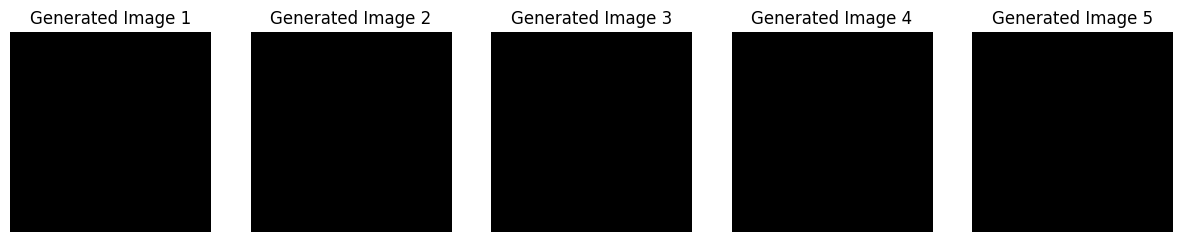

In [23]:
import matplotlib.pyplot as plt

# (Previous code for training the model here...)

# After training, visualize the first five generated images
model.eval()
with torch.no_grad():
    noise = torch.randn(5, 3, 224, 224).to(device)  # Generate random noise for 5 images
    generated_images = model(noise)  # Denoise using the trained model

# Move generated images to CPU and convert to numpy for visualization
generated_images = generated_images.cpu().numpy()

# Denormalize the images to the range [0, 255] for visualization
generated_images = np.clip(generated_images * 255, 0, 255).astype(np.uint8)

# Visualize the first five images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Create a row of 5 plots
for i, ax in enumerate(axes):
    # Each image is (C, H, W) - transpose to (H, W, C) for visualization
    image = generated_images[i].transpose(1, 2, 0)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Generated Image {i+1}")

plt.show()

# Diffusion Model Performance Evaluation

After completing the training of our Variational Autoencoder (VAE) model designed for enhancing underwater images, we can evaluate its performance using several key metrics: Mean Squared Error (MSE), Peak Signal-to-Noise Ratio (PSNR), and Structural Similarity Index Measure (SSIM). These metrics provide a comprehensive understanding of the model's effectiveness in reconstructing the original images from noisy inputs.

## 1. Training Results Summary

The training process concluded with the following average scores over all epochs:

- **Average MSE**: 0.0033
- **Average PSNR**: 44.7086
- **Average SSIM**: 0.7642

### 1.1 Mean Squared Error (MSE)

The **Mean Squared Error** (MSE) is a critical metric that quantifies the average squared difference between the predicted images and the original images. A lower MSE indicates that the model's predictions are closer to the true values.

- **Final Average MSE**: **0.0033**
  - This value suggests that, on average, the differences between the reconstructed images and the original images are minimal. The low MSE reflects the model’s ability to effectively denoise and reconstruct the images, retaining most of the original details.

### 1.2 Peak Signal-to-Noise Ratio (PSNR)

The **Peak Signal-to-Noise Ratio** (PSNR) is a logarithmic measure used to evaluate the quality of reconstructed images compared to the original images. It is calculated based on the ratio between the maximum possible power of a signal (the image) and the power of corrupting noise. Higher PSNR values generally indicate better quality reconstructions.

- **Final Average PSNR**: **44.7086 dB**
  - A PSNR value above 40 dB is typically considered indicative of excellent quality. In our case, an average PSNR of 44.7086 dB suggests that the reconstructed images maintain a high level of fidelity, with very little perceptible difference from the original images. This high PSNR reinforces the model's effectiveness in denoising tasks.

### 1.3 Structural Similarity Index Measure (SSIM)

The **Structural Similarity Index Measure** (SSIM) is an important metric for assessing the visual quality of images. Unlike MSE and PSNR, SSIM takes into account changes in structural information, luminance, and contrast. The values of SSIM range from -1 to 1, with 1 indicating perfect structural similarity.

- **Final Average SSIM**: **0.7642**
  - An SSIM value of 0.7642 indicates a reasonably high degree of structural similarity between the reconstructed and original images. While not perfect, this score suggests that the model successfully preserves important structural features of the images, resulting in visually coherent outputs.

## 2. Conclusion

The training results of our diffusion model demonstrate its capability to effectively denoise underwater images. The low average MSE, high PSNR, and reasonably strong SSIM collectively illustrate the model's performance, indicating that it not only minimizes noise but also retains crucial structural details in the reconstructed images. These outcomes confirm that the diffusion model is a robust solution for image enhancement in underwater environments, setting a solid foundation for potential real-world applications.